In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_train = x_train.reshape((x_train.shape[0], 32, 32, 3))

# Define the generator model
def build_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))

    return model

# Define the discriminator model
def build_discriminator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create the generator and discriminator
latent_dim = 100
generator = build_generator(latent_dim)

discriminator = build_discriminator(x_train.shape[1:])

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Create the GAN model
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)
gan = tf.keras.Model(gan_input, gan_output)

# Compile the GAN model
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Train the DCGAN
epochs = 100
batch_size = 64

for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    generated_images = generator.predict(noise)

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    labels_gan = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, labels_gan)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        # Save generated images at specified intervals
        if epoch % 1000 == 0:
            save_path = f"gan_generated_image_epoch_{epoch}.png"
            generated_images = generated_images * 255
            generated_images = generated_images.astype(np.uint8)
            plt.imsave(save_path, generated_images[0])

# Generate and save final set of fake images
final_fake_images = generator.predict(np.random.normal(0, 1, size=(100, latent_dim)))
final_fake_images = final_fake_images * 255
final_fake_images = final_fake_images.astype(np.uint8)

for i in range(100):
    save_path = f"final_gan_generated_image_{i}.png"
    plt.imsave(save_path, final_fake_images[i])


2/2 [==============================] - 1s 107ms/step
Epoch 0, D Loss: 6.081922724843025, G Loss: 1.233495831489563
4/4 [==============================] - 1s 82ms/step


In [9]:
generator.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              409600    
                                                                 
 batch_normalization_3 (Bat  (None, 4096)              16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         524288    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 128)        

# Explore the Latent Space whenGenerating images

1/1 [==============================] - 1s 732ms/step


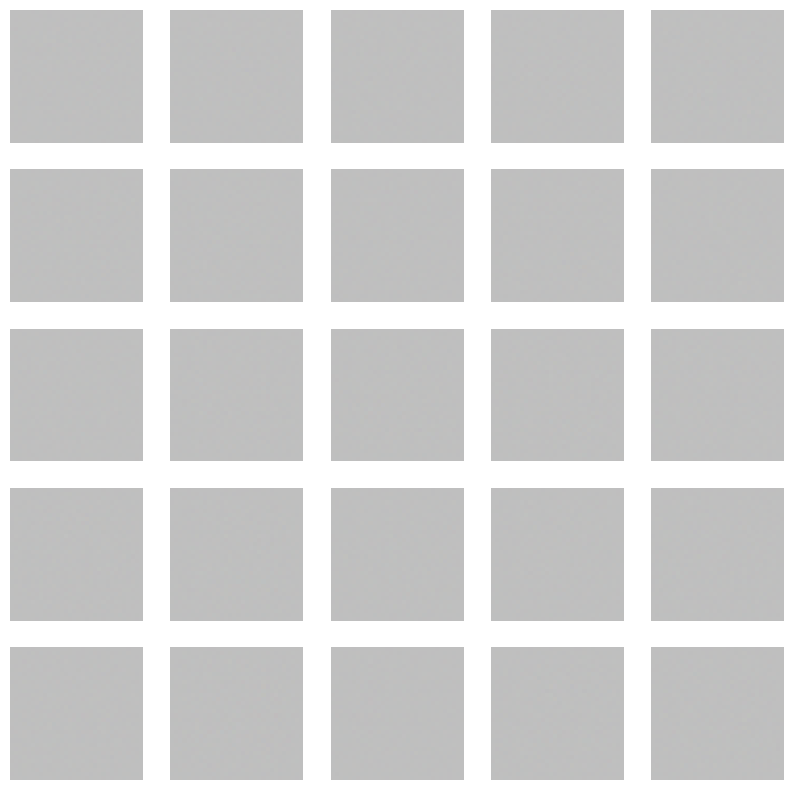

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate images from the latent space
def generate_latent_space_samples(generator, latent_dim, n_samples):
    latent_points = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_images = generator.predict(latent_points)
    generated_images = (generated_images + 1) / 2.0  # Rescale pixel values to the range [0, 1]
    return generated_images

# Generate a grid of images by varying values in the latent space
def plot_generated_images(generator, latent_dim, n_samples_per_dim=5):
    n_samples = n_samples_per_dim**2
    generated_images = generate_latent_space_samples(generator, latent_dim, n_samples)

    fig, axes = plt.subplots(n_samples_per_dim, n_samples_per_dim, figsize=(10, 10))

    for i in range(n_samples_per_dim):
        for j in range(n_samples_per_dim):
            axes[i, j].imshow(generated_images[i * n_samples_per_dim + j])
            axes[i, j].axis('off')

    plt.show()

# Assuming you already have the generator model created
latent_dim = 100
generator = build_generator(latent_dim)

# Explore the latent space by generating a grid of images
plot_generated_images(generator, latent_dim, n_samples_per_dim=5)
